# Siamese Network Training for Cup Container Similarity

이 노트북에서는 다회용기 구분을 위한 Siamese Network를 학습합니다.

## 목표
- CLIP 모델의 문제점(서로 다른 용기 간 유사도 0.90+) 해결
- 도메인 특화 임베딩 학습 (256차원)
- Triplet Loss + Semi-hard negative mining

## 아키텍처
- Encoder: MobileNetV3-Small (ImageNet pretrained)
- Embedding: 256차원 L2-normalized vectors
- Loss: Triplet Loss (margin=0.3)

## 데이터
- 7개 cup_codes, 총 220장
- Train/Val split: 80/20

## GPU 메모리 관리

GPU 메모리가 부족할 때 사용하세요:

```python
from gpu_memory_utils import clear_gpu_memory, print_gpu_memory

# GPU 메모리 상태 확인
print_gpu_memory()

# GPU 메모리 정리
clear_gpu_memory()
```

## 1. 환경 설정

In [1]:
import sys
import os

# Add parent directory to path for imports
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
from pathlib import Path
from collections import defaultdict
import random

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# GPU 메모리 정리
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 2060
GPU memory allocated: 0.00 MB
GPU memory reserved: 0.00 MB


## 2. 하이퍼파라미터 설정

In [2]:
# 모델 하이퍼파라미터
EMBEDDING_DIM = 256
ENCODER = 'mobilenet_v3_small'
PRETRAINED = True
DROPOUT_RATE = 0.3

# 학습 하이퍼파라미터
BATCH_SIZE = 21  # 7 cup_codes × 3 images per cup
P_K_SAMPLING = (7, 3)  # P classes, K samples per class
EPOCHS = 100
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4
IMG_SIZE = 224

# Loss 하이퍼파라미터
MARGIN = 0.3
MINING_STRATEGY = 'batch_semi_hard'  # 'batch_all', 'batch_hard', 'batch_semi_hard'
DISTANCE_METRIC = 'euclidean'  # 'euclidean' or 'cosine'

# 데이터
TRAIN_SPLIT = 0.8
NUM_WORKERS = 0  # Docker 환경 고려

# Early stopping
PATIENCE = 15

# 경로
DATA_DIR = './data/dataset_20251110_141636/types'  # cup_code별 디렉토리
MODEL_SAVE_DIR = './models/weights'
MODEL_NAME = 'siamese_network.pth'

print(f"Dataset directory: {DATA_DIR}")
print(f"Model will be saved to: {os.path.join(MODEL_SAVE_DIR, MODEL_NAME)}")
print(f"\nHyperparameters:")
print(f"  - Embedding dim: {EMBEDDING_DIM}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - P-K sampling: P={P_K_SAMPLING[0]}, K={P_K_SAMPLING[1]}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Margin: {MARGIN}")
print(f"  - Mining strategy: {MINING_STRATEGY}")

Dataset directory: ./data/dataset_20251110_141636/types
Model will be saved to: ./models/weights/siamese_network.pth

Hyperparameters:
  - Embedding dim: 256
  - Batch size: 21
  - P-K sampling: P=7, K=3
  - Learning rate: 0.0001
  - Margin: 0.3
  - Mining strategy: batch_semi_hard


## 3. Siamese Network 모델 정의

In [3]:
class SiameseNetwork(nn.Module):
    """MobileNetV3-Small 기반 Siamese Network"""
    
    def __init__(self, embedding_dim=256, pretrained=True, dropout_rate=0.3):
        super(SiameseNetwork, self).__init__()
        self.embedding_dim = embedding_dim
        
        # MobileNetV3-Small 백본 로드
        mobilenet = models.mobilenet_v3_small(pretrained=pretrained)
        
        # Feature extractor (분류기 제거)
        self.encoder = nn.Sequential(*list(mobilenet.children())[:-1])
        
        # MobileNetV3-Small 출력 차원: 576
        feature_dim = 576
        
        # Embedding head
        self.embedding_head = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(feature_dim, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        
        # 가중치 초기화
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Embedding head 가중치 초기화"""
        for m in self.embedding_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Feature extraction
        features = self.encoder(x)
        
        # Global average pooling
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features, 1)
        
        # Embedding
        embedding = self.embedding_head(features)
        
        # L2 normalization
        embedding = F.normalize(embedding, p=2, dim=1)
        
        return embedding

# 모델 테스트
print("Testing Siamese Network...")
test_model = SiameseNetwork(embedding_dim=EMBEDDING_DIM, pretrained=PRETRAINED)
test_input = torch.randn(4, 3, 224, 224)
test_output = test_model(test_input)
print(f"✓ Model test passed")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Output L2 norms: {torch.norm(test_output, p=2, dim=1)}")
print(f"  Total parameters: {sum(p.numel() for p in test_model.parameters()):,}")
del test_model, test_input, test_output

Testing Siamese Network...
✓ Model test passed
  Input shape: torch.Size([4, 3, 224, 224])
  Output shape: torch.Size([4, 256])
  Output L2 norms: tensor([1., 1., 1., 1.], grad_fn=<LinalgVectorNormBackward0>)
  Total parameters: 1,075,232


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 4. Triplet Loss 함수 정의

In [4]:
class OnlineTripletLoss(nn.Module):
    """Online Triplet Loss with batch-based mining"""
    
    def __init__(self, margin=0.3, mining_strategy='batch_semi_hard', distance='euclidean'):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.mining_strategy = mining_strategy
        self.distance = distance
    
    def _pairwise_distances(self, embeddings):
        """Compute pairwise distances"""
        if self.distance == 'euclidean':
            # Efficient: ||a-b||^2 = ||a||^2 + ||b||^2 - 2*a^T*b
            dot_product = torch.mm(embeddings, embeddings.t())
            square_norm = dot_product.diag()
            distances = square_norm.unsqueeze(0) - 2.0 * dot_product + square_norm.unsqueeze(1)
            distances = F.relu(distances)  # Numerical stability
            distances = torch.sqrt(distances + 1e-16)
            
            # Mask diagonal
            mask = torch.eye(distances.size(0), device=distances.device).bool()
            distances = distances.masked_fill(mask, 0)
            
        elif self.distance == 'cosine':
            # Cosine distance (assumes L2-normalized embeddings)
            cos_sim = torch.mm(embeddings, embeddings.t())
            distances = 1 - cos_sim
            
            # Mask diagonal
            mask = torch.eye(distances.size(0), device=distances.device).bool()
            distances = distances.masked_fill(mask, 0)
        
        return distances
    
    def _get_anchor_positive_mask(self, labels):
        """Mask for valid anchor-positive pairs"""
        indices_equal = torch.eye(labels.size(0), device=labels.device).bool()
        indices_not_equal = ~indices_equal
        labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
        return indices_not_equal & labels_equal
    
    def _get_anchor_negative_mask(self, labels):
        """Mask for valid anchor-negative pairs"""
        labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
        return ~labels_equal
    
    def forward(self, embeddings, labels):
        """Compute triplet loss"""
        pairwise_dist = self._pairwise_distances(embeddings)
        
        if self.mining_strategy == 'batch_hard':
            return self._batch_hard_triplet_loss(pairwise_dist, labels)
        elif self.mining_strategy == 'batch_semi_hard':
            return self._batch_semi_hard_triplet_loss(pairwise_dist, labels)
        else:
            raise ValueError(f"Unknown mining strategy: {self.mining_strategy}")
    
    def _batch_hard_triplet_loss(self, pairwise_dist, labels):
        """Use hardest positive and hardest negative"""
        # Hardest positive (furthest same-class)
        mask_anchor_positive = self._get_anchor_positive_mask(labels).float()
        anchor_positive_dist = pairwise_dist * mask_anchor_positive
        hardest_positive_dist, _ = anchor_positive_dist.max(dim=1, keepdim=True)
        
        # Hardest negative (closest different-class)
        mask_anchor_negative = self._get_anchor_negative_mask(labels).float()
        max_dist = pairwise_dist.max()
        anchor_negative_dist = pairwise_dist + max_dist * (1.0 - mask_anchor_negative)
        hardest_negative_dist, _ = anchor_negative_dist.min(dim=1, keepdim=True)
        
        # Triplet loss
        triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
        return triplet_loss.mean()
    
    def _batch_semi_hard_triplet_loss(self, pairwise_dist, labels):
        """Use semi-hard negatives"""
        mask_anchor_positive = self._get_anchor_positive_mask(labels).float()
        mask_anchor_negative = self._get_anchor_negative_mask(labels).float()
        
        # Hardest positive
        anchor_positive_dist = pairwise_dist * mask_anchor_positive
        hardest_positive_dist, _ = anchor_positive_dist.max(dim=1, keepdim=True)
        
        # Semi-hard negatives: d(a,p) < d(a,n) < d(a,p) + margin
        semi_hard_mask = (pairwise_dist > hardest_positive_dist) & \
                        (pairwise_dist < hardest_positive_dist + self.margin) & \
                        (mask_anchor_negative.bool())
        
        # Fallback to hard negatives if no semi-hard exist
        if semi_hard_mask.sum() == 0:
            return self._batch_hard_triplet_loss(pairwise_dist, labels)
        
        # Select closest semi-hard negative
        max_dist = pairwise_dist.max()
        semi_hard_dist = pairwise_dist.clone()
        semi_hard_dist[~semi_hard_mask] = max_dist
        semi_hard_negative_dist, _ = semi_hard_dist.min(dim=1, keepdim=True)
        
        # Triplet loss
        triplet_loss = F.relu(hardest_positive_dist - semi_hard_negative_dist + self.margin)
        return triplet_loss.mean()

# Loss 함수 테스트
print("Testing Triplet Loss...")
test_loss_fn = OnlineTripletLoss(margin=MARGIN, mining_strategy=MINING_STRATEGY)
test_embeddings = F.normalize(torch.randn(8, 256), p=2, dim=1)
test_labels = torch.tensor([0, 0, 1, 1, 2, 2, 3, 3])
test_loss = test_loss_fn(test_embeddings, test_labels)
print(f"✓ Loss test passed")
print(f"  Test loss value: {test_loss.item():.4f}")
del test_loss_fn, test_embeddings, test_labels, test_loss

Testing Triplet Loss...
✓ Loss test passed
  Test loss value: 0.2866


## 5. 데이터 전처리 및 증강

In [5]:
# 학습용 Transform (강력한 증강)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),  # 10% 확률로 흑백
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증용 Transform (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Transforms defined")

✓ Transforms defined


## 6. 데이터셋 및 데이터 로더

In [6]:
class CupContainerDataset(Dataset):
    """Cup container dataset for Siamese Network"""
    
    def __init__(self, image_paths, labels, cup_codes, transform=None):
        self.image_paths = image_paths
        self.labels = labels  # Numeric labels (0, 1, 2, ...)
        self.cup_codes = cup_codes  # String cup_codes
        self.transform = transform
        
        # Statistics
        print(f"Loaded {len(self.image_paths)} images")
        unique, counts = np.unique(labels, return_counts=True)
        for label_idx, count in zip(unique, counts):
            cup_code = list(set([cc for i, cc in enumerate(cup_codes) if labels[i] == label_idx]))[0]
            print(f"  - {cup_code} (label {label_idx}): {count} images")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        return image, label


class PKSampler(Sampler):
    """P-K Sampler: Sample P classes with K samples each"""
    
    def __init__(self, labels, p, k):
        self.labels = np.array(labels)
        self.p = p
        self.k = k
        
        # Group indices by label
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label].append(idx)
        
        self.unique_labels = list(self.label_to_indices.keys())
        self.num_batches = len(labels) // (p * k)
    
    def __iter__(self):
        for _ in range(self.num_batches):
            batch_indices = []
            
            # Sample P classes
            selected_labels = random.sample(self.unique_labels, self.p)
            
            # For each class, sample K samples
            for label in selected_labels:
                indices = self.label_to_indices[label]
                if len(indices) >= self.k:
                    sampled = random.sample(indices, self.k)
                else:
                    # If not enough samples, repeat with replacement
                    sampled = random.choices(indices, k=self.k)
                batch_indices.extend(sampled)
            
            yield batch_indices
    
    def __len__(self):
        return self.num_batches


def load_cup_container_dataset(data_dir):
    """Load cup container dataset from types/ directory"""
    data_dir = Path(data_dir)
    
    all_images = []
    all_cup_codes = []
    
    # Load from cup_code directories
    cup_code_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
    
    for cup_code_dir in cup_code_dirs:
        cup_code = cup_code_dir.name
        
        # Support both .jpg and .png files
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            for img_path in cup_code_dir.glob(ext):
                all_images.append(str(img_path))
                all_cup_codes.append(cup_code)
    
    # Convert cup_codes to numeric labels
    unique_cup_codes = sorted(list(set(all_cup_codes)))
    cup_code_to_label = {cc: i for i, cc in enumerate(unique_cup_codes)}
    all_labels = [cup_code_to_label[cc] for cc in all_cup_codes]
    
    print(f"\nLoaded {len(all_images)} images from {len(unique_cup_codes)} cup_codes")
    print(f"Cup codes: {unique_cup_codes}")
    
    # Statistics
    for cup_code in unique_cup_codes:
        count = all_cup_codes.count(cup_code)
        print(f"  - {cup_code}: {count} images")
    
    # Check if we have any images
    if len(all_images) == 0:
        raise ValueError(f"No images found in {data_dir}. Please check the directory structure.")
    
    # Train/Val split (stratified)
    train_images, val_images, train_labels, val_labels, train_cup_codes, val_cup_codes = train_test_split(
        all_images, all_labels, all_cup_codes,
        test_size=1-TRAIN_SPLIT,
        stratify=all_labels,
        random_state=42
    )
    
    print(f"\nSplit: {len(train_images)} train, {len(val_images)} val")
    
    return (
        train_images, val_images,
        train_labels, val_labels,
        train_cup_codes, val_cup_codes,
        cup_code_to_label,
        unique_cup_codes
    )

# Load dataset
(
    train_images, val_images,
    train_labels, val_labels,
    train_cup_codes, val_cup_codes,
    cup_code_to_label,
    unique_cup_codes
) = load_cup_container_dataset(DATA_DIR)

# Create datasets
train_dataset = CupContainerDataset(train_images, train_labels, train_cup_codes, transform=train_transform)
val_dataset = CupContainerDataset(val_images, val_labels, val_cup_codes, transform=val_transform)

# Create data loaders
# Use P-K sampler for training
P, K = P_K_SAMPLING
train_sampler = PKSampler(train_labels, p=P, k=K)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=NUM_WORKERS)

# Standard loader for validation
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Loaded 218 images from 7 cup_codes
Cup codes: ['black_starbucks', 'mug_cup', 'paper_cup', 'steel_cup', 'togo_dome', 'togo_flat', 'u_turn_cup']
  - black_starbucks: 21 images
  - mug_cup: 29 images
  - paper_cup: 19 images
  - steel_cup: 22 images
  - togo_dome: 19 images
  - togo_flat: 39 images
  - u_turn_cup: 69 images

Split: 174 train, 44 val
Loaded 174 images
  - black_starbucks (label 0): 17 images
  - mug_cup (label 1): 23 images
  - paper_cup (label 2): 15 images
  - steel_cup (label 3): 18 images
  - togo_dome (label 4): 15 images
  - togo_flat (label 5): 31 images
  - u_turn_cup (label 6): 55 images
Loaded 44 images
  - black_starbucks (label 0): 4 images
  - mug_cup (label 1): 6 images
  - paper_cup (label 2): 4 images
  - steel_cup (label 3): 4 images
  - togo_dome (label 4): 4 images
  - togo_flat (label 5): 8 images
  - u_turn_cup (label 6): 14 images

Train batches: 8
Val batches: 3


## 7. 샘플 이미지 확인

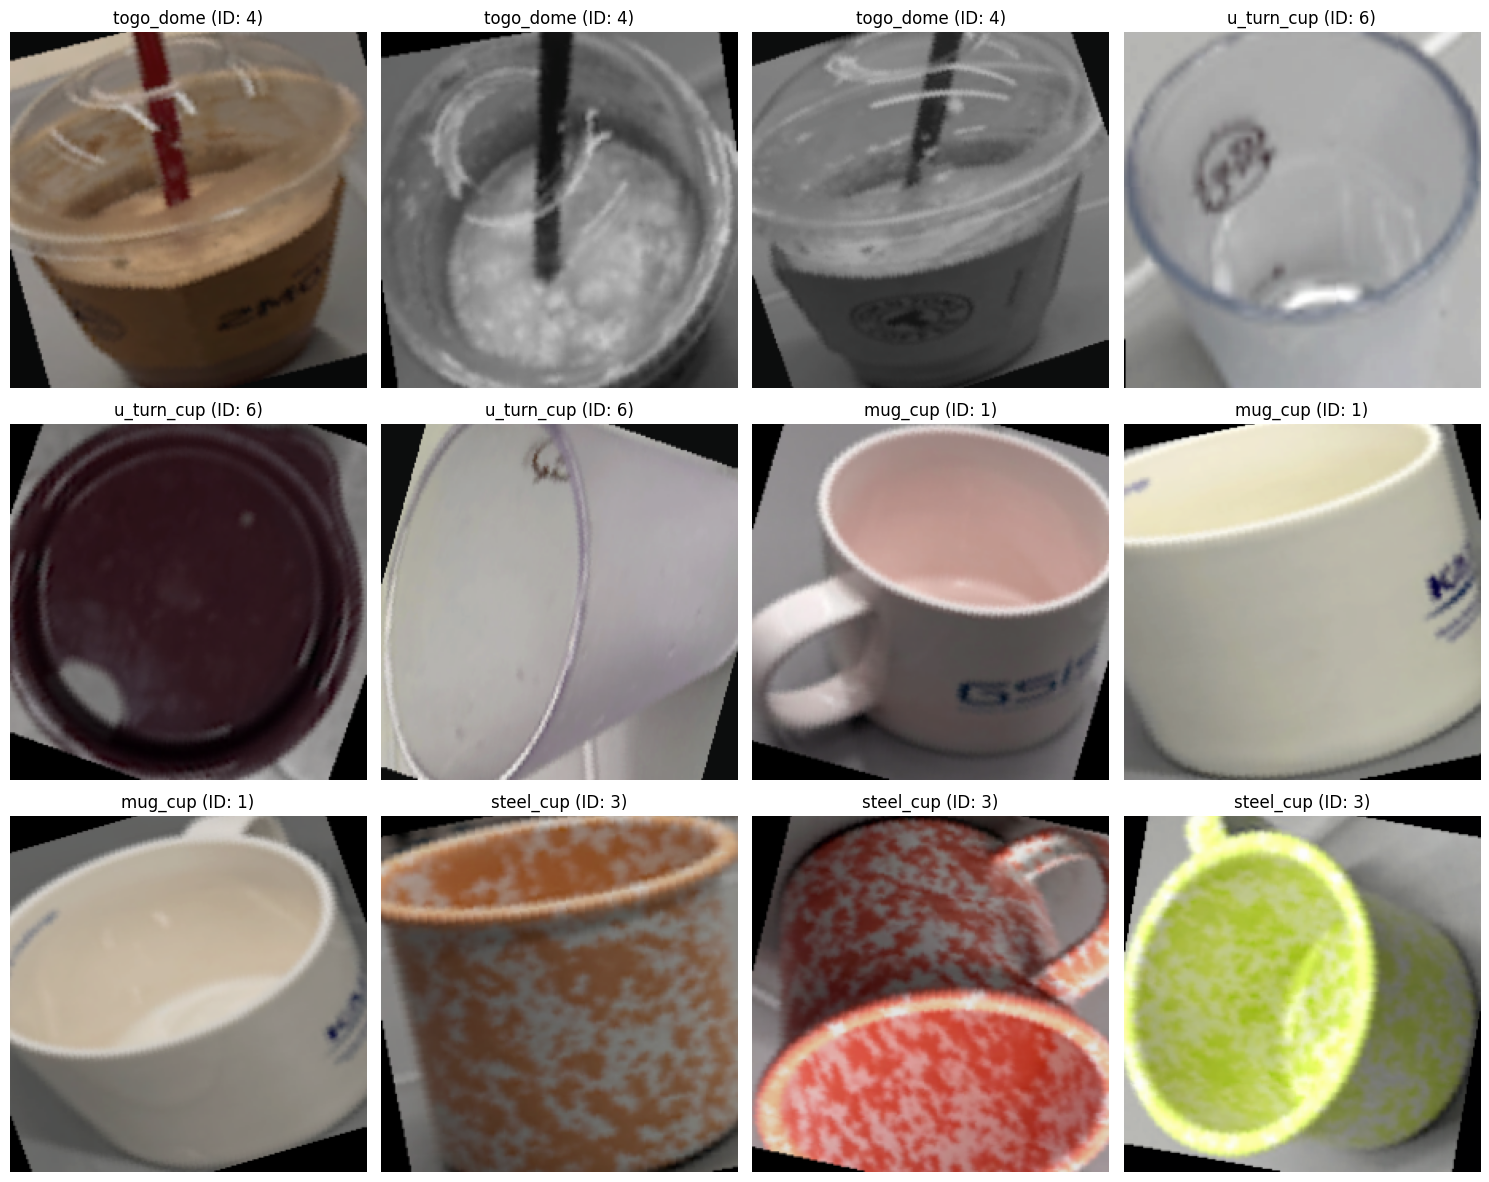

In [7]:
def show_batch_samples(loader, cup_codes, num_samples=12):
    """Display sample images from a batch"""
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{cup_codes[labels[i]]} (ID: {labels[i]})")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_batch_samples(train_loader, unique_cup_codes)

## 8. 모델, Loss, Optimizer 초기화

In [8]:
# GPU 메모리 정리
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"Available GPU memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1024**2:.2f} MB")

# 모델 초기화
model = SiameseNetwork(
    embedding_dim=EMBEDDING_DIM,
    pretrained=PRETRAINED,
    dropout_rate=DROPOUT_RATE
).to(device)

print(f"✓ Model loaded on {device}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

if device.type == 'cuda':
    print(f"  GPU memory after loading: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

# Loss 함수
criterion = OnlineTripletLoss(
    margin=MARGIN,
    mining_strategy=MINING_STRATEGY,
    distance=DISTANCE_METRIC
)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

print(f"✓ Loss, optimizer, and scheduler initialized")

Available GPU memory: 5730.12 MB


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model loaded on cuda
  Parameters: 1,075,232
  GPU memory after loading: 4.21 MB
✓ Loss, optimizer, and scheduler initialized


## 9. 학습 및 평가 함수

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        optimizer.zero_grad()
        embeddings = model(images)
        loss = criterion(embeddings, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / num_batches
    return epoch_loss


def validate(model, loader, criterion, device):
    """Validation"""
    model.eval()
    running_loss = 0.0
    num_batches = 0
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            
            running_loss += loss.item()
            num_batches += 1
            
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    epoch_loss = running_loss / num_batches
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.concatenate(all_labels)
    
    return epoch_loss, all_embeddings, all_labels


def compute_intra_inter_distances(embeddings, labels):
    """Compute intra-class and inter-class distances"""
    intra_distances = []
    inter_distances = []
    
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            dist = np.linalg.norm(embeddings[i] - embeddings[j])
            
            if labels[i] == labels[j]:
                intra_distances.append(dist)
            else:
                inter_distances.append(dist)
    
    return np.array(intra_distances), np.array(inter_distances)

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


## 10. 학습 실행

**참고**: 초기 실험에서는 EPOCHS를 10으로 설정하여 빠르게 테스트하고, 이후 100으로 설정하여 전체 학습을 수행합니다.

In [10]:
# 학습 히스토리
history = {
    'train_loss': [],
    'val_loss': [],
    'intra_dist': [],
    'inter_dist': []
}

best_val_loss = float('inf')
patience_counter = 0

# 모델 저장 경로
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model_path = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    # 학습
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 검증
    val_loss, val_embeddings, val_labels = validate(model, val_loader, criterion, device)
    
    # Intra/Inter 거리 계산
    intra_dist, inter_dist = compute_intra_inter_distances(val_embeddings, val_labels)
    
    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['intra_dist'].append(intra_dist.mean() if len(intra_dist) > 0 else 0)
    history['inter_dist'].append(inter_dist.mean() if len(inter_dist) > 0 else 0)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Intra-class distance: {history['intra_dist'][-1]:.4f}")
    print(f"Inter-class distance: {history['inter_dist'][-1]:.4f}")
    
    # 학습률 스케줄러
    scheduler.step(val_loss)
    
    # 최고 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'embedding_dim': EMBEDDING_DIM,
            'cup_code_to_label': cup_code_to_label,
            'unique_cup_codes': unique_cup_codes
        }, model_path)
        
        print(f"✓ Best model saved (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*50}")
print(f"Training completed! Best Val Loss: {best_val_loss:.4f}")


Epoch 1/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.06it/s]


Train Loss: 0.2770
Val Loss: 0.1545
Intra-class distance: 0.9096
Inter-class distance: 1.1402
✓ Best model saved (Val Loss: 0.1545)

Epoch 2/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.91it/s]


Train Loss: 0.2727
Val Loss: 0.1502
Intra-class distance: 0.9194
Inter-class distance: 1.1802
✓ Best model saved (Val Loss: 0.1502)

Epoch 3/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.09it/s]


Train Loss: 0.2727
Val Loss: 0.1393
Intra-class distance: 0.8986
Inter-class distance: 1.1857
✓ Best model saved (Val Loss: 0.1393)

Epoch 4/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.02it/s]


Train Loss: 0.2676
Val Loss: 0.1387
Intra-class distance: 0.8902
Inter-class distance: 1.2035
✓ Best model saved (Val Loss: 0.1387)

Epoch 5/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.48it/s]


Train Loss: 0.2598
Val Loss: 0.1296
Intra-class distance: 0.8776
Inter-class distance: 1.2154
✓ Best model saved (Val Loss: 0.1296)

Epoch 6/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.32it/s]


Train Loss: 0.2516
Val Loss: 0.1190
Intra-class distance: 0.8621
Inter-class distance: 1.2250
✓ Best model saved (Val Loss: 0.1190)

Epoch 7/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.46it/s]


Train Loss: 0.2336
Val Loss: 0.1087
Intra-class distance: 0.8375
Inter-class distance: 1.2271
✓ Best model saved (Val Loss: 0.1087)

Epoch 8/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.19it/s]


Train Loss: 0.2367
Val Loss: 0.1001
Intra-class distance: 0.8047
Inter-class distance: 1.2181
✓ Best model saved (Val Loss: 0.1001)

Epoch 9/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.12it/s]


Train Loss: 0.2132
Val Loss: 0.0927
Intra-class distance: 0.7755
Inter-class distance: 1.2187
✓ Best model saved (Val Loss: 0.0927)

Epoch 10/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.77it/s]


Train Loss: 0.1848
Val Loss: 0.0837
Intra-class distance: 0.7656
Inter-class distance: 1.2280
✓ Best model saved (Val Loss: 0.0837)

Epoch 11/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.84it/s]


Train Loss: 0.1695
Val Loss: 0.0757
Intra-class distance: 0.7597
Inter-class distance: 1.2386
✓ Best model saved (Val Loss: 0.0757)

Epoch 12/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 23.81it/s]


Train Loss: 0.1506
Val Loss: 0.0766
Intra-class distance: 0.7594
Inter-class distance: 1.2607

Epoch 13/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.34it/s]


Train Loss: 0.1601
Val Loss: 0.0729
Intra-class distance: 0.7507
Inter-class distance: 1.2792
✓ Best model saved (Val Loss: 0.0729)

Epoch 14/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.25it/s]


Train Loss: 0.1275
Val Loss: 0.0629
Intra-class distance: 0.7440
Inter-class distance: 1.3057
✓ Best model saved (Val Loss: 0.0629)

Epoch 15/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.83it/s]


Train Loss: 0.1135
Val Loss: 0.0622
Intra-class distance: 0.7187
Inter-class distance: 1.3169
✓ Best model saved (Val Loss: 0.0622)

Epoch 16/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.26it/s]


Train Loss: 0.1147
Val Loss: 0.0547
Intra-class distance: 0.6867
Inter-class distance: 1.3146
✓ Best model saved (Val Loss: 0.0547)

Epoch 17/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.09it/s]


Train Loss: 0.0967
Val Loss: 0.0530
Intra-class distance: 0.6722
Inter-class distance: 1.3272
✓ Best model saved (Val Loss: 0.0530)

Epoch 18/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.35it/s]


Train Loss: 0.0976
Val Loss: 0.0581
Intra-class distance: 0.6657
Inter-class distance: 1.3407

Epoch 19/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.00it/s]


Train Loss: 0.0768
Val Loss: 0.0542
Intra-class distance: 0.6564
Inter-class distance: 1.3528

Epoch 20/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.53it/s]


Train Loss: 0.0667
Val Loss: 0.0582
Intra-class distance: 0.6430
Inter-class distance: 1.3631

Epoch 21/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.83it/s]


Train Loss: 0.0633
Val Loss: 0.0512
Intra-class distance: 0.6345
Inter-class distance: 1.3702
✓ Best model saved (Val Loss: 0.0512)

Epoch 22/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 19.12it/s]


Train Loss: 0.0450
Val Loss: 0.0390
Intra-class distance: 0.6264
Inter-class distance: 1.3767
✓ Best model saved (Val Loss: 0.0390)

Epoch 23/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.19it/s]


Train Loss: 0.0608
Val Loss: 0.0328
Intra-class distance: 0.6176
Inter-class distance: 1.3868
✓ Best model saved (Val Loss: 0.0328)

Epoch 24/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.93it/s]


Train Loss: 0.0378
Val Loss: 0.0283
Intra-class distance: 0.6098
Inter-class distance: 1.3951
✓ Best model saved (Val Loss: 0.0283)

Epoch 25/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.83it/s]


Train Loss: 0.0310
Val Loss: 0.0246
Intra-class distance: 0.5969
Inter-class distance: 1.4029
✓ Best model saved (Val Loss: 0.0246)

Epoch 26/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.99it/s]


Train Loss: 0.0332
Val Loss: 0.0217
Intra-class distance: 0.5870
Inter-class distance: 1.4111
✓ Best model saved (Val Loss: 0.0217)

Epoch 27/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.70it/s]


Train Loss: 0.0183
Val Loss: 0.0215
Intra-class distance: 0.5757
Inter-class distance: 1.4148
✓ Best model saved (Val Loss: 0.0215)

Epoch 28/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.75it/s]


Train Loss: 0.0146
Val Loss: 0.0207
Intra-class distance: 0.5724
Inter-class distance: 1.4169
✓ Best model saved (Val Loss: 0.0207)

Epoch 29/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.37it/s]


Train Loss: 0.0231
Val Loss: 0.0181
Intra-class distance: 0.5728
Inter-class distance: 1.4193
✓ Best model saved (Val Loss: 0.0181)

Epoch 30/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.12it/s]


Train Loss: 0.0119
Val Loss: 0.0175
Intra-class distance: 0.5730
Inter-class distance: 1.4244
✓ Best model saved (Val Loss: 0.0175)

Epoch 31/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.29it/s]


Train Loss: 0.0119
Val Loss: 0.0165
Intra-class distance: 0.5706
Inter-class distance: 1.4269
✓ Best model saved (Val Loss: 0.0165)

Epoch 32/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.65it/s]


Train Loss: 0.0027
Val Loss: 0.0153
Intra-class distance: 0.5695
Inter-class distance: 1.4317
✓ Best model saved (Val Loss: 0.0153)

Epoch 33/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.88it/s]


Train Loss: 0.0116
Val Loss: 0.0152
Intra-class distance: 0.5662
Inter-class distance: 1.4359
✓ Best model saved (Val Loss: 0.0152)

Epoch 34/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.23it/s]


Train Loss: 0.0095
Val Loss: 0.0157
Intra-class distance: 0.5697
Inter-class distance: 1.4392

Epoch 35/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.82it/s]


Train Loss: 0.0038
Val Loss: 0.0177
Intra-class distance: 0.5701
Inter-class distance: 1.4429

Epoch 36/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.57it/s]


Train Loss: 0.0060
Val Loss: 0.0171
Intra-class distance: 0.5636
Inter-class distance: 1.4479

Epoch 37/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.25it/s]


Train Loss: 0.0097
Val Loss: 0.0155
Intra-class distance: 0.5567
Inter-class distance: 1.4513

Epoch 38/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 26.51it/s]


Train Loss: 0.0094
Val Loss: 0.0162
Intra-class distance: 0.5515
Inter-class distance: 1.4584

Epoch 39/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 20.61it/s]


Train Loss: 0.0107
Val Loss: 0.0160
Intra-class distance: 0.5413
Inter-class distance: 1.4572
Epoch 00039: reducing learning rate of group 0 to 5.0000e-05.

Epoch 40/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.34it/s]


Train Loss: 0.0105
Val Loss: 0.0158
Intra-class distance: 0.5396
Inter-class distance: 1.4573

Epoch 41/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 24.44it/s]


Train Loss: 0.0087
Val Loss: 0.0158
Intra-class distance: 0.5383
Inter-class distance: 1.4600

Epoch 42/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.02it/s]


Train Loss: 0.0019
Val Loss: 0.0154
Intra-class distance: 0.5382
Inter-class distance: 1.4625

Epoch 43/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.56it/s]


Train Loss: 0.0055
Val Loss: 0.0198
Intra-class distance: 0.5385
Inter-class distance: 1.4645

Epoch 44/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 25.00it/s]


Train Loss: 0.0051
Val Loss: 0.0195
Intra-class distance: 0.5367
Inter-class distance: 1.4654

Epoch 45/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 27.72it/s]


Train Loss: 0.0012
Val Loss: 0.0195
Intra-class distance: 0.5370
Inter-class distance: 1.4661
Epoch 00045: reducing learning rate of group 0 to 2.5000e-05.

Epoch 46/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 22.19it/s]


Train Loss: 0.0021
Val Loss: 0.0195
Intra-class distance: 0.5369
Inter-class distance: 1.4682

Epoch 47/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 18.37it/s]


Train Loss: 0.0009
Val Loss: 0.0192
Intra-class distance: 0.5360
Inter-class distance: 1.4700

Epoch 48/100
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.12it/s]

Train Loss: 0.0035
Val Loss: 0.0194
Intra-class distance: 0.5334
Inter-class distance: 1.4692

Early stopping triggered after 48 epochs

Training completed! Best Val Loss: 0.0152


## 11. 학습 곡선 시각화

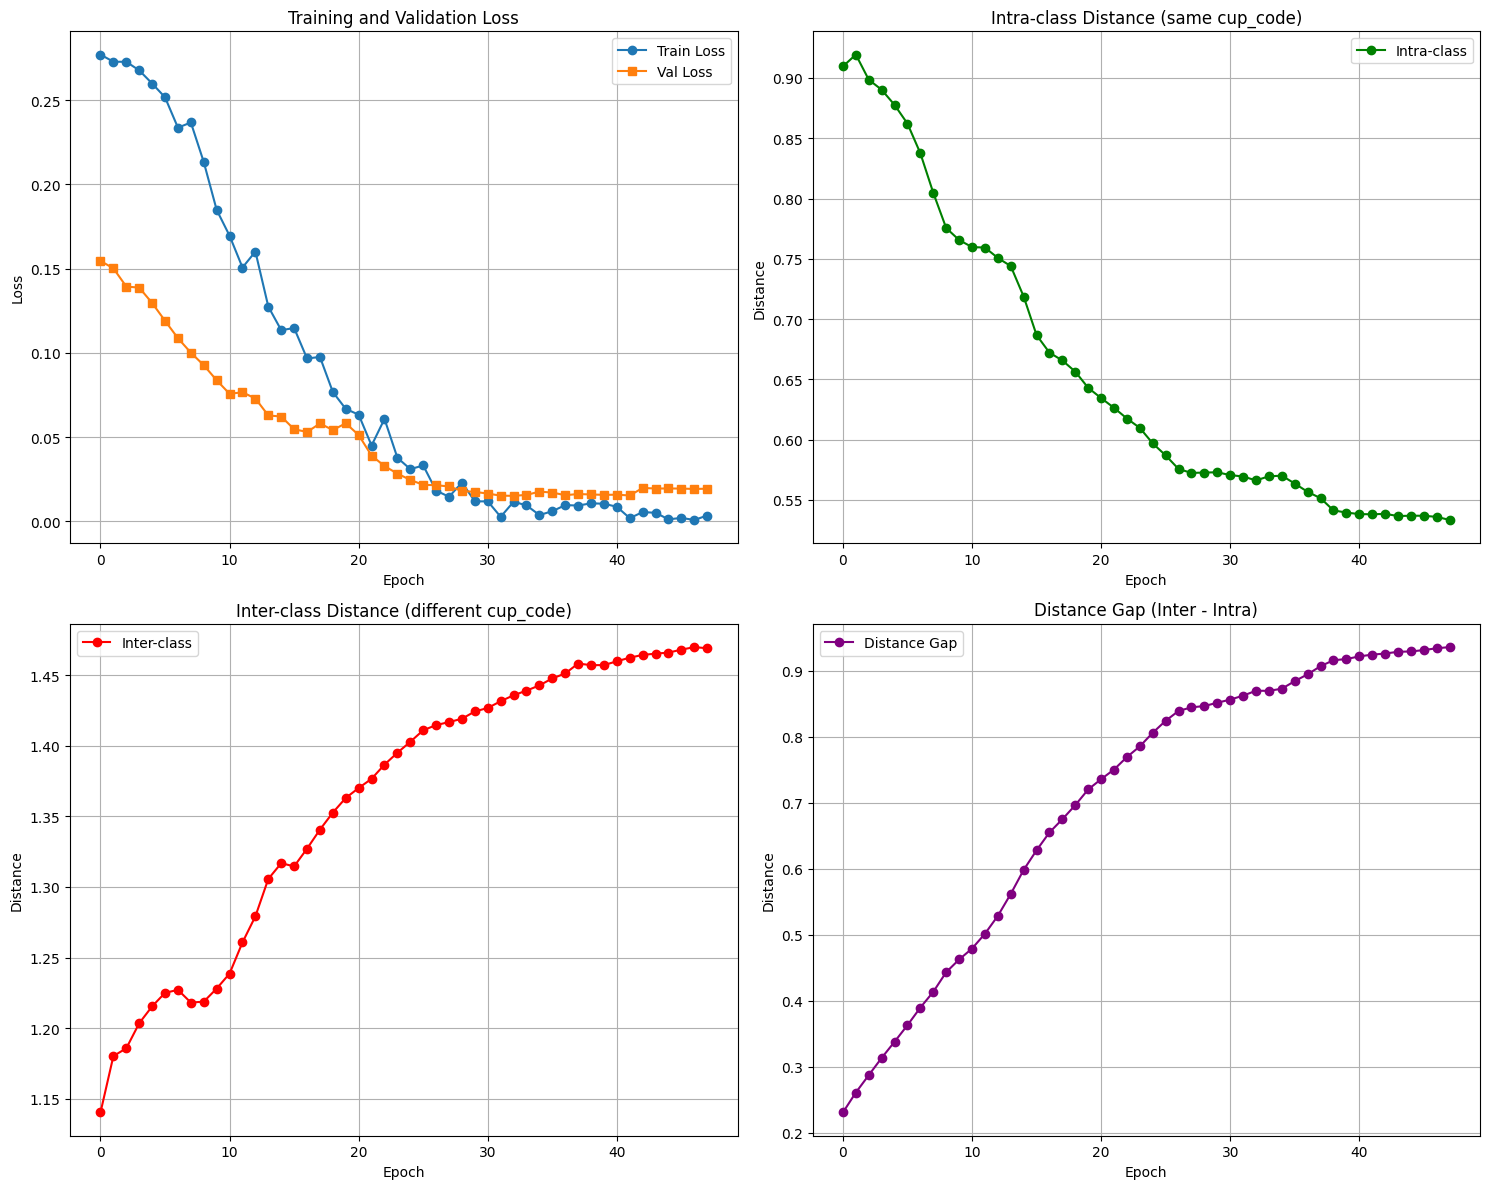

Final metrics:
  Intra-class distance: 0.5334 (target: < 0.3)
  Inter-class distance: 1.4692 (target: > 0.8)
  Distance gap: 0.9358 (larger is better)


In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Intra-class distance
ax2.plot(history['intra_dist'], label='Intra-class', color='green', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Distance')
ax2.set_title('Intra-class Distance (same cup_code)')
ax2.legend()
ax2.grid(True)

# Inter-class distance
ax3.plot(history['inter_dist'], label='Inter-class', color='red', marker='o')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Distance')
ax3.set_title('Inter-class Distance (different cup_code)')
ax3.legend()
ax3.grid(True)

# Distance gap (Inter - Intra)
distance_gap = np.array(history['inter_dist']) - np.array(history['intra_dist'])
ax4.plot(distance_gap, label='Distance Gap', color='purple', marker='o')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Distance')
ax4.set_title('Distance Gap (Inter - Intra)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"Final metrics:")
print(f"  Intra-class distance: {history['intra_dist'][-1]:.4f} (target: < 0.3)")
print(f"  Inter-class distance: {history['inter_dist'][-1]:.4f} (target: > 0.8)")
print(f"  Distance gap: {distance_gap[-1]:.4f} (larger is better)")

## 12. t-SNE 시각화

Validation: 100%|██████████| 3/3 [00:00<00:00, 23.12it/s]


Computing t-SNE...


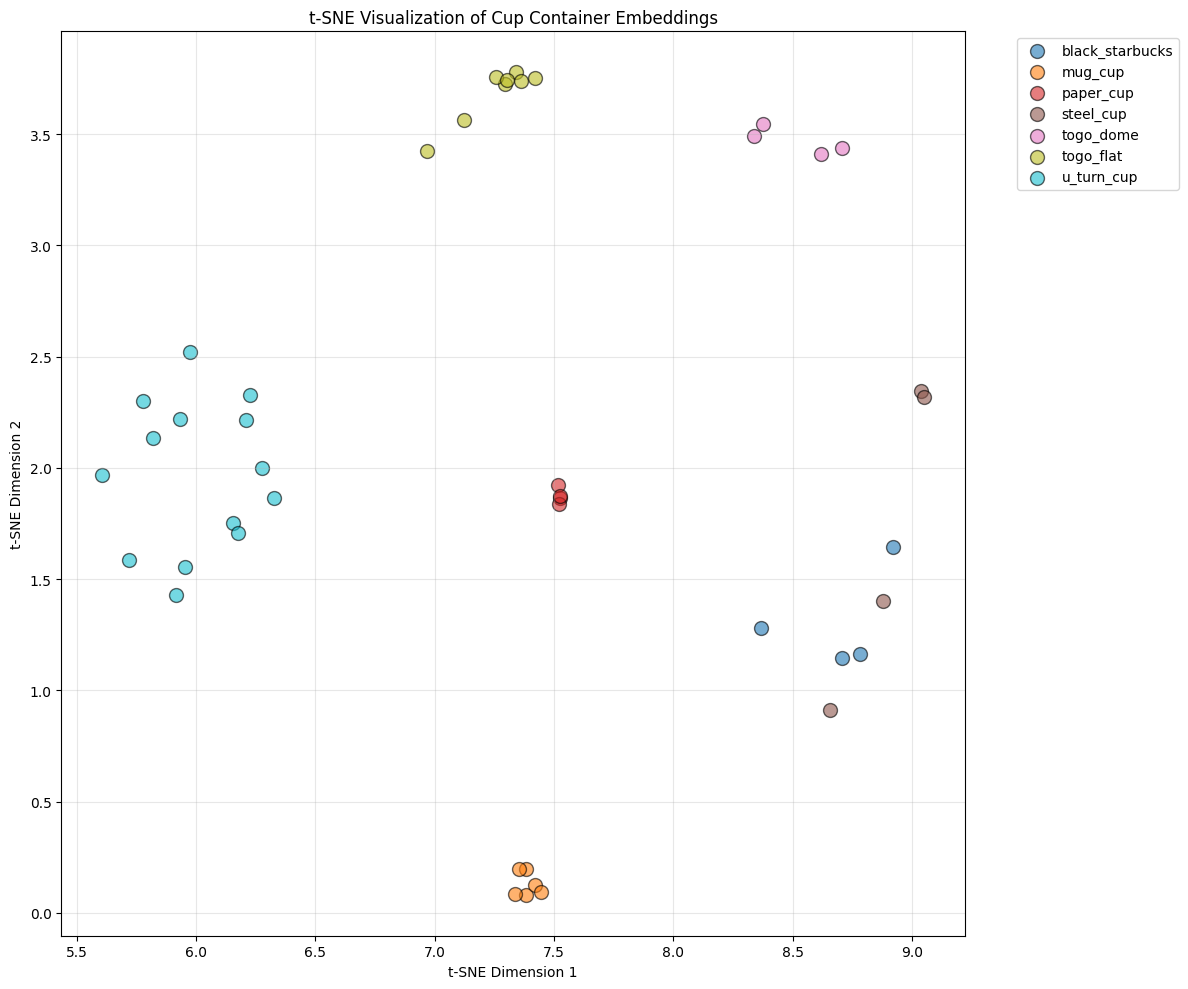

✓ t-SNE visualization complete


In [12]:
# 최고 모델 로드
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 전체 검증 세트 임베딩 생성
_, val_embeddings, val_labels = validate(model, val_loader, criterion, device)

# t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(val_embeddings)-1))
embeddings_2d = tsne.fit_transform(val_embeddings)

# Plot
plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_cup_codes)))

for label_idx, cup_code in enumerate(unique_cup_codes):
    mask = val_labels == label_idx
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[label_idx]],
        label=cup_code,
        s=100,
        alpha=0.6,
        edgecolors='black'
    )

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Cup Container Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ t-SNE visualization complete")

## 13. 유사도 행렬 (Similarity Matrix)

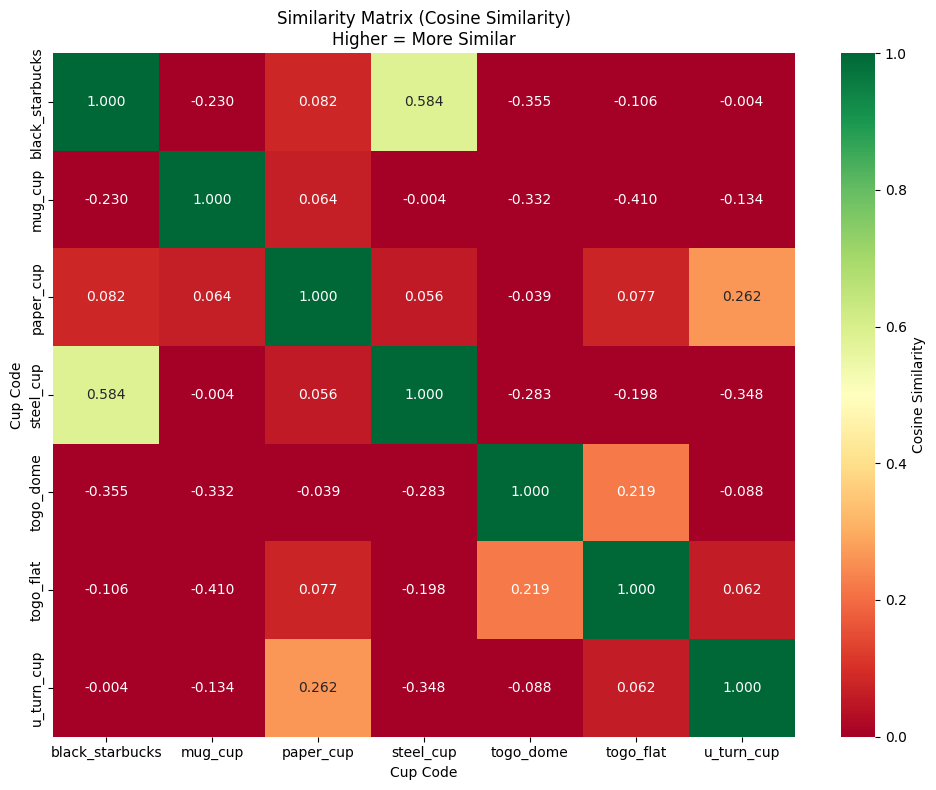


Most similar cup code pairs:
  black_starbucks ↔ steel_cup: 0.5840
  paper_cup ↔ u_turn_cup: 0.2623
  togo_dome ↔ togo_flat: 0.2194
  black_starbucks ↔ paper_cup: 0.0820
  paper_cup ↔ togo_flat: 0.0768
  mug_cup ↔ paper_cup: 0.0643
  togo_flat ↔ u_turn_cup: 0.0622
  paper_cup ↔ steel_cup: 0.0560
  black_starbucks ↔ u_turn_cup: -0.0044
  mug_cup ↔ steel_cup: -0.0045


In [13]:
# cup_code별 평균 임베딩 계산
cup_code_embeddings = {}

for label_idx, cup_code in enumerate(unique_cup_codes):
    mask = val_labels == label_idx
    cup_code_embeddings[cup_code] = val_embeddings[mask].mean(axis=0)

# 유사도 행렬 계산 (코사인 유사도)
n_codes = len(unique_cup_codes)
similarity_matrix = np.zeros((n_codes, n_codes))

for i, cup_code_i in enumerate(unique_cup_codes):
    emb_i = cup_code_embeddings[cup_code_i]
    for j, cup_code_j in enumerate(unique_cup_codes):
        emb_j = cup_code_embeddings[cup_code_j]
        # Cosine similarity
        similarity = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
        similarity_matrix[i, j] = similarity

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    xticklabels=unique_cup_codes,
    yticklabels=unique_cup_codes,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.xlabel('Cup Code')
plt.ylabel('Cup Code')
plt.title('Similarity Matrix (Cosine Similarity)\nHigher = More Similar')
plt.tight_layout()
plt.show()

# 가장 유사한 쌍 출력 (대각선 제외)
print("\nMost similar cup code pairs:")
pairs = []
for i in range(n_codes):
    for j in range(i+1, n_codes):
        pairs.append((unique_cup_codes[i], unique_cup_codes[j], similarity_matrix[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)
for cup_i, cup_j, sim in pairs[:10]:
    print(f"  {cup_i} ↔ {cup_j}: {sim:.4f}")

## 14. 모델 저장 (최종)

In [14]:
# cup_code_embeddings를 JSON으로 저장
embeddings_json_path = os.path.join(MODEL_SAVE_DIR, 'cup_code_embeddings_siamese.json')

embeddings_json = {
    cup_code: emb.tolist()
    for cup_code, emb in cup_code_embeddings.items()
}

with open(embeddings_json_path, 'w') as f:
    json.dump(embeddings_json, f, indent=2)

print(f"✓ Cup code embeddings saved to {embeddings_json_path}")
print(f"✓ Model checkpoint saved to {model_path}")
print(f"\nModel info:")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")
print(f"  - Number of cup codes: {len(unique_cup_codes)}")
print(f"  - Best validation loss: {best_val_loss:.4f}")
print(f"  - Final intra-class distance: {history['intra_dist'][-1]:.4f}")
print(f"  - Final inter-class distance: {history['inter_dist'][-1]:.4f}")

✓ Cup code embeddings saved to ./models/weights/cup_code_embeddings_siamese.json
✓ Model checkpoint saved to ./models/weights/siamese_network.pth

Model info:
  - Embedding dimension: 256
  - Number of cup codes: 7
  - Best validation loss: 0.0152
  - Final intra-class distance: 0.5334
  - Final inter-class distance: 1.4692


## 요약

### 학습된 모델
- **모델 파일**: `./models/weights/siamese_network.pth`
- **임베딩 파일**: `./models/weights/cup_code_embeddings_siamese.json`
- **Embedding dimension**: 256

### 성능 목표
- Intra-class distance: < 0.3 (같은 용기는 가까이)
- Inter-class distance: > 0.8 (다른 용기는 멀리)
- Distance gap: > 0.5

### 다음 단계
1. `05_embedding_evaluation.ipynb`에서 CLIP vs Siamese 성능 비교
2. FastAPI 서버에 Siamese 모델 통합 (`/generate-embedding-v2` 엔드포인트)
3. 실전 데이터로 추가 테스트